# BaseNetApi

On this set of JuPyter Notebooks we will learn the BaseNetApi from skratch.

We will start with some basic imports:

In [1]:
import os
from IPython.display import Image
from src.basenet import BaseNetModel, BaseNetDatabase, BaseNetCompiler, __version__ 
__version__

'1.6.0'

## BaseNetDataset Tutorial

**BaseNet** can work with four different type of datasets:

* TensorFlow Datasets.
* Numpy Datasets.
* Pandas Datasets.
* Raw list datasets.

The API will transform this datasets into their own class Dataset: ``BaseNetDataset``.

Imagine having your own function that loads your own NP, TF, PD stored in your db path:

In this tutorial, we will use the ``TensorFlow MNIST dataset`` as an example.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Paths of the different datasets.
my_database_paths = {'numpy':      './db/np_ds.npy', 
                     'tensorflow': './db/tf_ds', 
                     'pandas':     './db/pd_ds.csv', 
                     'raw':        './db/raw_ds'}

# Loads a Numpy Dataset to 'x' and 'y' ndarray values.
def load_my_numpy_data(path):
    with open(path, 'rb') as file:
        x = np.load(file)
        y = np.load(file)
    return x, y

# Loads a Pandas CSV Dataset to 'x' and 'y' list values.
def load_my_pandas_data(path):
    pd_df = pd.read_csv(path)
    return list(pd_df.x), list(pd_df.y)
    
# Loads a TensorFlow Dataset to 'x' and 'y' eager tensor or ndarray values.
def load_my_tf_data(path, to_numpy: bool = False):
    tf_dset = tf.data.Dataset.load(path)
    x = list()
    y = list()
    for batched in tf_dset:
        x.append(batched['image'])
        y.append(batched['label'])
    x, y = tf.convert_to_tensor(x), tf.convert_to_tensor(y)
    if to_numpy:
        return x.numpy(), y.numpy()
    return x, y

Now we can load the Datasets into the BaseNetDataset Class and save it as a BaseNetDatabase.

You can also load a BaseNetDatabase.

### For NumPy

In [3]:
my_data_x, my_data_y = load_my_numpy_data(my_database_paths['numpy'])
print('y shape: ', my_data_y.shape)
print('x shape: ', my_data_x.shape)

y shape:  (60000,)
x shape:  (60000, 28, 28, 1)


### For TensorFlow

In [4]:
my_data_x, my_data_y = load_my_tf_data(my_database_paths['tensorflow'])
print('y shape: ', my_data_y.shape)
print('x shape: ', my_data_x.shape)

y shape:  (60000,)
x shape:  (60000, 28, 28, 1)


### For Pandas

**Note**: In Pandas, we only took 2000 elements of the MNIST tutorial Dataset. As Pandas is not optimal for image processing.

In [5]:
my_data_x, my_data_y = load_my_pandas_data(my_database_paths['pandas'])
print('y shape: ', len(my_data_y))
print('x shape: ', len(my_data_x))

y shape:  2000
x shape:  2000


### For BaseNet

Now in **BaseNet**, we can build a ``BaseNetDatabase`` with the 'x' and 'y' values extracted from the different type of sources.

* First, we create a ``distribution`` that randomly shuffles the data into train, validation and test datasets.
* The train data will be used to train the weigths and values of the deep learning models.
* The validation data will be used to check that the training process is not overfitting to the training data.
* The test data is not used during the training process and is only used to show results.

Let's assume we have a Numpy array as raw data.

In [6]:
my_data_x, my_data_y = load_my_numpy_data(my_database_paths['numpy'])
distribution = {'train': 60, 'test': 5, 'val': 35}
mydb = BaseNetDatabase(my_data_x, my_data_y, distribution=distribution, name='My Test MNIST Database With 60000 instances')
print(mydb)
print('Is my Database well built?: ', mydb.is_valid)

BaseNetDatabase with 60000 instances.
Is my Database well built?:  True


Now the BaseNetDataset contains 60 000 instances with our data. We can see somne relevant information in the public variables.


In [7]:
print('Database Name:\t\t', mydb.name, '\n\nSize of the Database:\t', mydb.size, '\t (elements)\nWith distribution:\t', mydb.distribution, '\t\t (%)\nWith value types:\t', mydb.dtype, ' (x, y)')

Database Name:		 My Test MNIST Database With 60000 instances 

Size of the Database:	 (36000, 21000, 3000) 	 (elements)
With distribution:	 (60, 35, 5) 		 (%)
With value types:	 ('float32', 'float32')  (x, y)


We can save our Dataset once built with the ``BaseNetDatabase.save()`` method. And load it with the ``BaseNetDatabase.load()`` method.

In [8]:
mydb.save('./db/mydb.db')
BaseNetDatabase.load('./db/mydb.db')

BaseNetDatabase with 60000 instances.

## BaseNetCompiler Tutorial

BaseNetCompiler takes the model architecture and builds a BaseNetModel with the given parameters. You can build your BaseNetCompiler from Python code only or a .yaml file. In the following case, we are showing how to create a sequential model with a MLP architecture.

The method ``BaseNetCompiler.show_devs()`` show the available devices to train your models; in this case, we should only have a CPU core running in our Notebook, with its default state in ``'Train'``.

In [9]:
layers = [
    {'Dense': ((255,), {})},
    {'Dense': ((64,), {'activation': 'relu'})},
    {'Dropout': ((0.5,), {})}
]

my_devs = BaseNetCompiler.show_devs()
my_devs

{'/device:CPU:0': 'Train'}

To create a model compiler, you must call the ``BaseNetCompiler()``. Note that this API uses TensorFlow and Keras to build the models, so you may need to refer to Keras or TensorFlow documentation.

    (
        io_shape: tuple =        The shape of the input to the model and output to the model (input_shape, output_values)
        compile_options: dict =  {'loss': Keras loss function, 'optimizer': Keras optimizer}
        devices: dict =          A dictionary with the devices and their role ('Train', 'Idle', 'Other'); you may use the .show_devs() method
        layers: list =           A list of layers as previously shown
        name: str =              Some name
    )
    
    
Later, you can call the ``.compile()`` method to build a ``BaseNetModel`` with the compiler. Note that TensorFlow can do some console vomitting during the process.

In [10]:
my_first_model = BaseNetCompiler(
    io_shape=((28, 28, 1), 10), 
    compile_options={'loss': 'categorical_crossentropy', 'optimizer': 'adam'}, 
    devices=my_devs, 
    layers=layers,
    name='my_first_model'
).compile()
my_first_model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model object with the following parameters:
Compiler: Compiler with 3 layers, options:
{'loss': 'categorical_crossentropy', 'optimizer': 'adam'}
Summary: Model: "my_first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 dense (Dense)               (None, 28, 28, 255)       510       
                                                                 
 dense_1 (Dense)             (None, 28, 28, 64)        16384     
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 output (Dense)              (None, 28, 28, 10)        650       
                                                                 
Total params: 17,544
Trainable

You can use a ``YAML`` file to build your model. There are two examples of yaml files in the ``yaml_path`` directory. The example1 won't run on this Notebook as there is a GPU specified on the ``YAML`` file.

In [11]:
yaml_path = './compilers/example0.yaml'
my_first_model = BaseNetCompiler.build_from_yaml(yaml_path, verbose=True).compile()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


## BaseNetModel Tutorial

To link our database to our model, we must use the ``.add_database()`` method. You can add several Databases to your model and train the Database you need in different phases of your training process.

In [12]:
my_first_model = my_first_model.add_database(mydb)

You can see the list of databases in the ``breech`` attribute:

In [13]:
my_first_model.breech

[BaseNetDatabase with 60000 instances.]

Once you build and compile a ``BaseNetModel`` with a ```BaseNetCompiler.compile()``` method, you can make use of all the
methods that the ``BaseNetModel`` provides:

* ```BaseNetModel.load()```: This method loads a tf.keras.model and the compiler from the given path.
* ```BaseNetModel.save()```: This method saves a tf.keras.model and the compiler into the given path.
* ```BaseNetModel.print()```: This method renders a ``.png`` image of the model into the given path.
* ```BaseNetModel.add_database()```: The ``BaseNetModel`` contains a breech of databases. It is a list with all the loaded
databases previously. This method adds a database from a path or from a ```BaseNetDatabase``` object.
* ```BaseNetModel.predict()```: Performs a prediction given an input.
* ```BaseNetModel.evaluate()```: Evaluates the model with the pointed database test subset.
* ```BaseNetModel.fit()```: Trains the model with the pointed database.
* ```BaseNetModel.call()```: Merges two models into one. It can be used as a function.

At this point, we tested ``load()``, ``save()`` and ``add_database()`` methods. Let's visualize out model with the ``print()`` method:

Representation at ./my_first_model.png:



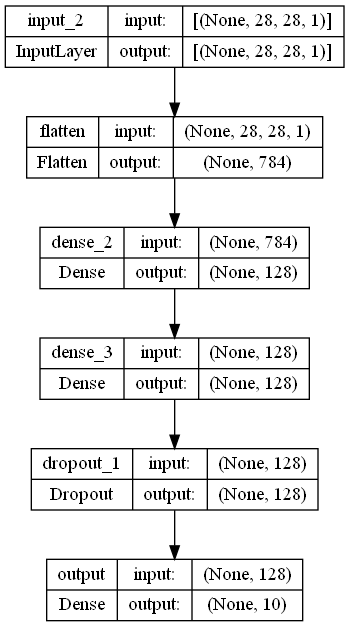

In [14]:
my_first_model.print('./')
print(f'Representation at ./{my_first_model.name}.png:\n')
Image(f"./{my_first_model.name}.png")

Now that we introduced some of the utilities that ``BaseNetModel`` offers, we jump into the training and predict methods:

To train our model, we just need to call the ``fit()`` method:

In [15]:
# Ignore the following code for now:
# Error before training in the Test Dataset.
error = my_first_model.evaluate(0, tf.keras.metrics.categorical_crossentropy)
error_before = np.mean(error)
# Ignore the previous code for now.

results = my_first_model.fit(0, epochs=5, tensorboard=False)

94/94 [==============================] - 0s 2ms/step
Epoch 1/5
282/282 [==============================] - 6s 11ms/step - loss: 6.6473 - val_loss: 1.1406
Epoch 2/5
282/282 [==============================] - 2s 6ms/step - loss: 1.4387 - val_loss: 0.9206
Epoch 3/5
282/282 [==============================] - 2s 7ms/step - loss: 1.2506 - val_loss: 0.8389
Epoch 4/5
282/282 [==============================] - 2s 7ms/step - loss: 1.1477 - val_loss: 0.7946
Epoch 5/5
282/282 [==============================] - 2s 7ms/step - loss: 1.0466 - val_loss: 0.7232


As you can notice, the ``add_database()`` method already identifies the nature of the labels and builds a binary representation so the Deep Learning model can ingest the data. Note that the
original data is a vector of integers. A Deep Learning model does not work with shuch information. To solve it, the API implements an automatic conversion to categorical values.

Now, let's check the performance during the training process:

In [16]:
results.get()['loss']

[6.647305965423584,
 1.4387198686599731,
 1.2505954504013062,
 1.1477240324020386,
 1.0465946197509766]

As we can see, the model is increasing its performance along the epochs. However, we implemented a basic MLP architecture and we can see a overfitting in the model (val_loss is higher):

In [17]:
results.get()['val_loss']

[1.1405531167984009,
 0.920598566532135,
 0.8389185070991516,
 0.7946209907531738,
 0.7232266068458557]

Now, let's evaluate the model in the Test Dataset, for this, we call the ``evaluate()`` method. This method takes as input an evaluation function. We are using the 'categorical_crossentropy' loss function in our model.
This is because we told in the ``YAML`` file that our loss was that exact function. This function can be accessed in ``tf.keras.metrics.categorical_crossentropy``.

In [18]:
error = my_first_model.evaluate(0, tf.keras.metrics.categorical_crossentropy)
error_now = np.mean(error)

94/94 [==============================] - 0s 2ms/step


We ran before a piece of code that evaluated the model before the fitting process. We can see the difference between the error in pre-training and the error after training:

In [19]:
print(f'Performance before:\t{round(error_before, 2)}\nPerformance after:\t{round(error_now, 2)}\nDifference:\t\t{round(error_now - error_before, 2)}')

Performance before:	86.16000366210938
Performance after:	83.5199966430664
Difference:		-2.630000114440918


We can also predict the output with the ``predict()`` method. Let's take a piece of the Test Database.

In [20]:
def test_the_model(model, print_all=False, ranged=(0, 20)):
    # We take some values from the test dataset:
    from_which = ranged[0]
    how_many_values = ranged[1]
    x, y = model.breech[0].xtest[from_which:from_which + how_many_values], model.breech[0].ytest[from_which:from_which + how_many_values]

    # Compute the predictions and get the values with the max, as the output is categorical (no threshold):
    pred = model.predict(x)
    x_predicted = tf.math.argmax(pred, axis=1).numpy()
    y_predicted = tf.math.argmax(y, axis=1).numpy()

    # Print the results:
    hits = 0
    if print_all:
        print('Predictions:')
    for x_pred, y_pred in zip(x_predicted, y_predicted):
        hits += 1 if x_pred == y_pred else 0
        if print_all:
            print(f'\tPredicted: {x_pred} and it was {y_pred}. ', x_pred == y_pred)
    hrate = 100 * hits/how_many_values
    if hrate < 45:
        print(f'Hit rate: {hrate}% (very low: minimum is 10%)')
        return False
    elif 45 <= hrate < 70:
        print(f'Hit rate: {hrate}%')
        return False
    elif 70 <= hrate < 98:
        print(f'Hit rate: {hrate}% (nice)')
        print('Congratulations, you suceeded!')
    else:
        print(f'Hit rate: {hrate}% (amazing model!)')
        print('Congratulations, you suceeded with amazing performance!')
    return True
        
passed_the_test = test_the_model(my_first_model, print_all=True)

1/1 [==============================] - 0s 72ms/step
Predictions:
	Predicted: 8 and it was 8.  True
	Predicted: 3 and it was 7.  False
	Predicted: 9 and it was 9.  True
	Predicted: 5 and it was 5.  True
	Predicted: 2 and it was 4.  False
	Predicted: 9 and it was 6.  False
	Predicted: 2 and it was 8.  False
	Predicted: 0 and it was 0.  True
	Predicted: 4 and it was 4.  True
	Predicted: 1 and it was 3.  False
	Predicted: 1 and it was 1.  True
	Predicted: 1 and it was 1.  True
	Predicted: 0 and it was 0.  True
	Predicted: 2 and it was 4.  False
	Predicted: 6 and it was 6.  True
	Predicted: 1 and it was 2.  False
	Predicted: 1 and it was 2.  False
	Predicted: 8 and it was 9.  False
	Predicted: 1 and it was 2.  False
	Predicted: 2 and it was 2.  True
Hit rate: 50.0%


### Concatenate two models
You can also create a multi-input model with the ``call()`` method or calling the model as a function. The model takes 3 inputs:

* Other model: Other BaseNetModel.
* Parallel: A boolean telling if the second model is in parallel or is after the first model.
* Name: A name for your merged model.

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


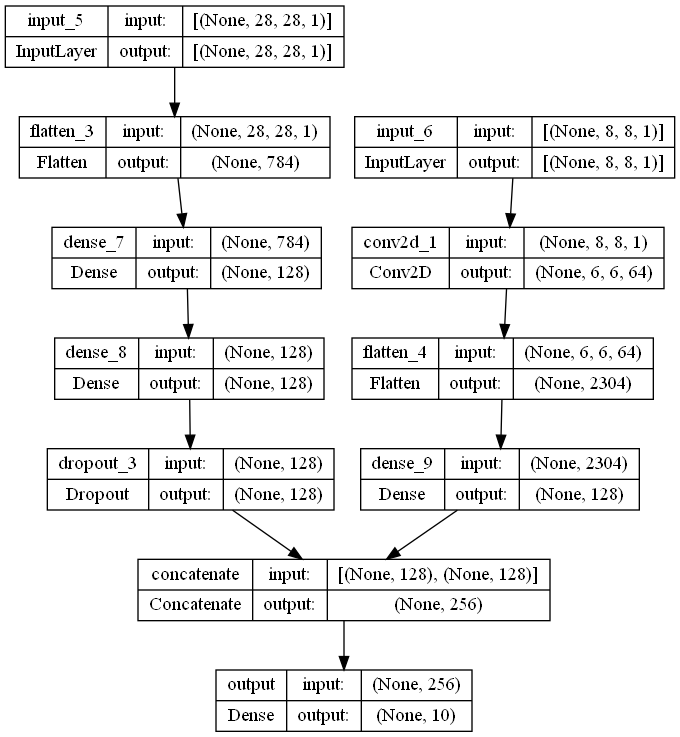

In [21]:
# Build both models:
first_model = BaseNetCompiler.build_from_yaml('./compilers/example0.yaml', verbose=True).compile().add_database(mydb)
second_model = BaseNetCompiler.build_from_yaml('./compilers/example1.yaml', verbose=True).compile()
# Call the first model with ``parallel=True`` argument.
first_model(second_model, parallel=True, name='merged_model')
# Model printing.
first_model.print('./')
Image(f"./{first_model.name}.png")

And this is how you can do it in series:

**Important**: You cannot join a BaseNetModel that was already been concatenated in parallel (because it has no traceback of the parallel layers).

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


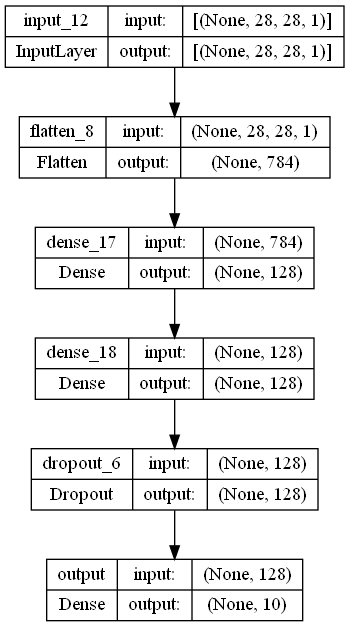

In [25]:
first_model = BaseNetCompiler.build_from_yaml('./compilers/example0.yaml', verbose=True).compile().add_database(mydb)
third_model = BaseNetCompiler.build_from_yaml('./compilers/example2.yaml', verbose=True).compile()
first_model(third_model, parallel=False, name='merged_model')
# Model printing.
first_model.print('./')
Image(f"./{first_model.name}.png")

## Extra:

An excercise for this tutorial is to find a good Deep Learning model that achieves a nice performance. A hint for this optional exercise is that the Dataset is the MNIST Dataset. Try the code below and modify only the YAML file:

**Hint**: A CNN should work fine! (CNN is implemented with Conv2D, see Keras documentation to build Deep Learning models)

The YAML file to modify is in ``"./exercises/modify_this_yaml.yaml"``.

In [26]:
# valid_solution = './exercises/valid_solution.yaml' [Goes from 70 - 85 %]
# your_exercise = './exercises/modify_this_yaml.yaml' [Goes from 40 - 55 %] Improve it to +70%.
# Do not touch this code:
def try_your_model(epochs, print_all=False):
    modify_this_yaml_path = './exercises/modify_this_yaml.yaml'
    new_model = BaseNetCompiler.build_from_yaml(modify_this_yaml_path, verbose=True).compile().add_database(mydb)
    new_model.fit(0, epochs=epochs, tensorboard=False)
    if test_the_model(new_model, print_all=print_all, ranged=(100, 200)):
        new_model.print('./')
        print('Congratulations! Your model passed the test.')
        return Image(f"./{new_model.name}.png")
    return None

try_your_model(10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Epoch 1/10
282/282 [==============================] - 5s 10ms/step - loss: 7.4985 - val_loss: 1.2638
Epoch 2/10
282/282 [==============================] - 2s 6ms/step - loss: 1.4724 - val_loss: 0.9419
Epoch 3/10
282/282 [==============================] - 2s 6ms/step - loss: 1.2219 - val_loss: 0.8307
Epoch 4/10
282/282 [==============================] - 2s 6ms/step - loss: 1.0663 - val_loss: 0.7091
Epoch 5/10
282/282 [==============================] - 2s 6ms/step - loss: 0.9549 - val_loss: 0.6438
Epoch 6/10
282/282 [==============================] - 2s 6ms/step - loss: 0.8651 - val_loss: 0.6174
Epoch 7/10
282/282 [==============================] - 2s 6ms/step - loss: 0.8154 - val_loss: 0.5391
Epoch 8/10
282/282 [==============================] - 2s 6ms/step - loss: 0.7762 - val_loss: 0.5374
Epoch 9/10
282/282 [==============================] - 2s 6ms/step - loss: 0.7350 - val_loss: 0.5435
Epoch 10/10
7/7 [==============================] - 1s 2ms/step
Hit rate: 40.5% (very low: minimum i

You reached the end of the basic-use tutorial. Crongratulations!